# Building A Handwritten Digits Classifier

Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf)

In this project, we'll:
- Explore why image classification is a hard task
- Observe the limitations of traditional machine learning models for image classification
- Train, test, and improve a few different deep neural networks for image classification

Image Classification is hard because:
1. Each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
2. Images are often downsampled to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately.
3. An image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression.

The aim of the project is to explore the effectiveness of deep, feedforward neural networks at classifying images.

In [1]:
%matplotlib inline
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load_digit() to get hand-written digits dataset fro UCI
data_digits = load_digits()

In [2]:
data_digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [3]:
data = pd.DataFrame(data_digits['data'])
labels = pd.Series(data_digits['target'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


# Visualize the images from Tabular form data
-----
- The load_digits() function returns a copy of the hand-written digits dataset from UCI.
- Dataframes are a tabular representation of data, each image is represented as a row of pixel values.
    - To visualize an image from the dataframe, reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid
    - To reshape the image, convert data columns to a numpy array (excluding the label column) and pass the result into that into the numpy.reshape() function:
    - Visualize data using pyplot.imshow() function
    - To display multiple images in one matplotlib figure, use the equivalent **axes.imshow()**

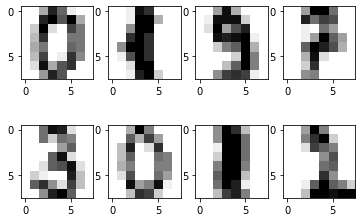

In [4]:
fig,ax = plt.subplots(2,4) #2 rows,4 columns

n1 = [0,99,199,299]
n2 = [999,1099,1199,1299]
column = range(0,4)
row = [0,1]

for i in row:
    for (j,k) in zip(column,n1): 
        ax[i,j].imshow(data.iloc[k].values.reshape(8,8), cmap = 'gray_r')
for j,k in zip(column,n2): 
    ax[1,j].imshow(data.iloc[k].values.reshape(8,8), cmap = 'gray_r')
        
        

# K-Nearest Neighbors Model
----
- Linear and logistic regression models make assumptions about the linearity between the features and the output labels
- The k-nearest neighbors algorithm make no such assumption.
    - Allows to capture nonlinearity in the data
    - Compares every unseen observation in the test set to all  training observations to look for similar (or the "nearest") observations
    

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# Train Test Split
def train_knn(train_features,train_labels,n):
    knn = KNeighborsClassifier(n_neighbors =n)
    knn.fit(train_features,train_labels)
    return knn

def test(test_features, test_labels, model):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return accuracy

def cross_validation(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    
    for train_index, test_index in kf.split(data):
        
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels = labels.loc[train_index]
        test_labels = labels.loc[test_index]
        model = train_knn(train_features,train_labels,k)
        accuracy = test(test_features, test_labels,model)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

In [6]:
knn_one_accuracies = cross_validation(1)
np.mean(knn_one_accuracies)

0.9677233358079684

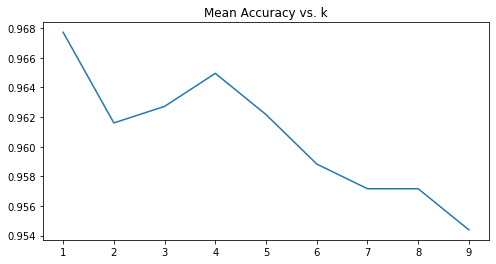

In [7]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validation(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

# Neural Network With One Hidden Layer
-----
- There are a few downsides to using k-nearest neighbors
    - High memory usage
    - No model representation to debug and explore
    

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

# Train Test Split
def train_nn(train_features,train_labels,neuron_arch):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features,train_labels)
    return mlp

def test(test_features, test_labels, model):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return accuracy

def cross_validation(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    
    for train_index, test_index in kf.split(data):
        
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels = labels.loc[train_index]
        test_labels = labels.loc[test_index]
        model = train_nn(train_features,train_labels,neuron_arch)
        accuracy = test(test_features, test_labels,model)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

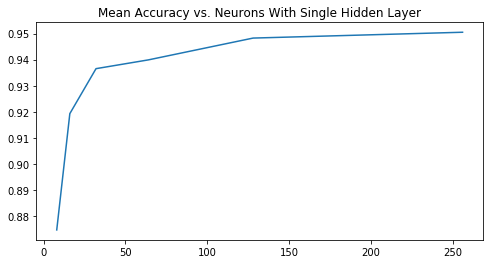

In [18]:
nn_one_accuracies = []
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]

for n in nn_one_neurons:
    nn_accuracies = cross_validation(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons With Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

In [19]:
nn_one_accuracies

[0.874806763285024,
 0.9193273875882572,
 0.9365440356744705,
 0.9399033816425121,
 0.9482534373838721,
 0.9504849498327759]

# Neural Network with 2 Hidden Layers

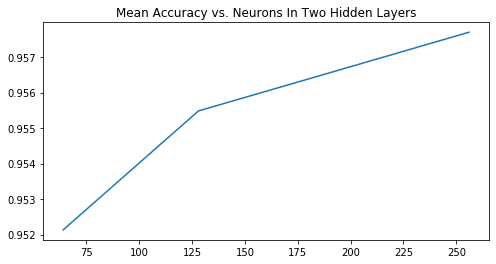

In [10]:
nn_two_neurons = [  
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validation(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

In [12]:
nn_two_accuracies

[0.9521306607275427, 0.9554825538233112, 0.9577010640930463]

# Neural Network With Three Hidden Layers And 6 Folds
----


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

# Train Test Split
def train_nn(train_features,train_labels,neuron_arch):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features,train_labels)
    return mlp

def test(test_features, test_labels, model):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return accuracy

def cross_validation_6(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state = 2)
    
    for train_index, test_index in kf.split(data):
        
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels = labels.loc[train_index]
        test_labels = labels.loc[test_index]
        model = train_nn(train_features,train_labels,neuron_arch)
        accuracy = test(test_features, test_labels,model)
        fold_accuracies.append(accuracy)
        
    return fold_accuracies

/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/paras.patel/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

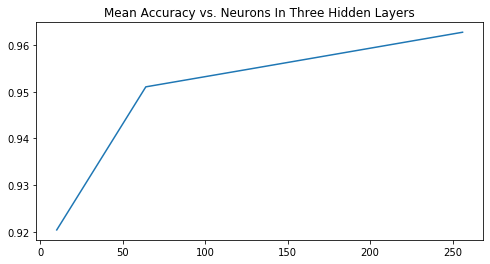

In [20]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128),
    (256,256,256)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validation_6(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [17]:
nn_three_accuracies

[0.8998494983277592, 0.9448996655518395, 0.9560535117056856]

# Conclusion
------
- K-Nearest Neighbors Model:
    - Accuracy 97%
- Using 1 hidden layer:
    - Adding more neurons to the single hidden layer helped to improve accuracy 
    - approximately 87% to approximately 95%.
- Using 2 hidden layers:
    - improved our simple accuracy to 95.5%
- Using 3 hidden layers:
    - improved our simple accuracy to 95.6%